In [1]:
import os
import numpy as np
from skimage.feature import daisy
from skimage import io
from pathlib import Path
import matplotlib.pyplot as plt

"""
KNN implementation with daisy descriptors
trainX: Descriptors of train data
trainY: Labels of the train data
sampleTest: Descriptors of a test sample
k: Number of nearest neighbors
metric: Distance metric, minkowski (default) or mahalanobis
"""
def KNN(trainX, trainY, sampleTest, k, metric='minkowski'):
    distances = []
    descSize = len(sampleTest)

    if metric == 'minkowski':
        for sample in trainX:
            distance = 0
            for i in range(descSize):
                difference = abs(sampleTest[i] - sample[i])
                distance = distance + pow(difference, 3)
            distance = np.cbrt(distance)
            distances.append(distance)

    elif metric == 'mahalanobis':
        trainXtran = np.transpose(trainX)
        covMat = np.cov(trainXtran)
        """
        Added a very small value (10^-6) to the diagonal of the covariance matrix before the inversion
        to overcome the computation problems when the matrix is very close to being singular
        Check the following link to see more detailed info about LinAlgError: Singular matrix
        https://stackoverflow.com/a/28269334
        """
        covMatInv = np.linalg.inv(covMat + np.eye(covMat.shape[0])*(10**-6))
        for sample in trainX:
            diffVector = []
            for i in range(descSize):
                diffVector.append(sampleTest[i] - sample[i])
            diffVectorTran = np.transpose(diffVector)
            distance = np.matmul(np.matmul(diffVectorTran, covMatInv), diffVector)
            distance = np.sqrt(distance)
            distances.append(distance)

    info = list(zip(distances, trainY))
    info.sort()
    distances, labels = zip(*info)
    labels = labels[:k]
    return max(set(labels), key=labels.count) # Return the most frequent label among the k-nearest neighbors

DESC_SIZE = 4104
cwd = os.getcwd()
trainPath = os.path.join(cwd, 'drive/MyDrive/YuksekLisans/DLAPP/HW1/train')
testPath = os.path.join(cwd, 'drive/MyDrive/YuksekLisans/DLAPP/HW1/test')
trainX = []
trainY = []
testX = []
testImages = []

for root, dirs, files in os.walk(trainPath):
    for file in files:
        if file.endswith('.jpg'):
            filePath = os.path.join(root, file)
            pathParts = Path(root).parts
            labelName = pathParts[-1]
            trainY.append(labelName)
            img = io.imread(filePath, as_gray=True)
            descs = daisy(img, step=180, radius=58, rings=2, histograms=256, orientations=8, visualize=False)
            descs = descs.flatten()
            descs = descs[:DESC_SIZE]
            trainX.append(descs)
  
for root, dirs, files in os.walk(testPath):
    for file in files:
        if file.endswith('.jpg'):
            filePath = os.path.join(root, file)
            img = io.imread(filePath, as_gray=True)
            descs = daisy(img, step=180, radius=58, rings=2, histograms=256, orientations=8, visualize=False)
            descs = descs.flatten()
            descs = descs[:DESC_SIZE]
            testX.append(descs)
            testImages.append(img) # Store test images to show them with predictions later

# Calculate row and column size to subplot the test images with predictied labels      
testSize = len(testX)
row = np.floor(np.sqrt(testSize))
col = np.ceil(testSize/row)

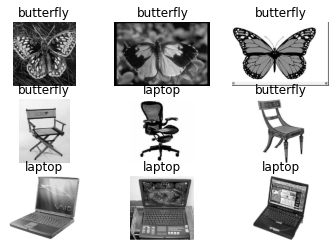

In [2]:
# Test with minkowski distance
for i in range(testSize):
    pred = KNN(trainX, trainY, testX[i], 7, 'minkowski')
    plt.subplot(row, col, i+1)
    plt.title(pred)
    plt.axis('off')
    plt.imshow(testImages[i], cmap='gray')

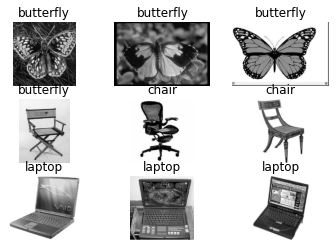

In [3]:
# Test with mahalanobis distance
for i in range(testSize):
    pred = KNN(trainX, trainY, testX[i], 7, 'mahalanobis')
    plt.subplot(row, col, i+1)
    plt.title(pred)
    plt.axis('off')
    plt.imshow(testImages[i], cmap='gray')